# Analysing Public Speaking Skills in TED Talks

<b>Aim</b>: 
- Perform EDA on TED Talks dataset (downloaded from https://www.kaggle.com/rounakbanik/ted-talks).
- Compute engagement scores on the TED audio files. 
- Analyse patterns in speech features corresponding to the engagement scores.

Note: The TED audio files were downloaded using the following scraper code.

https://github.com/The-Gupta/TED-Scraper/blob/master/Scraper.ipynb

It is observed that the first 20 seconds of each talk is usually the introduction of the speaker and the last 10 seconds of the audio file consists of claps. In order to avoid this noise, the these segments are not considered while loading the audio files for preprocessing (in extract_features.py). Also, only the first five minutes of the talk is considered for analysis (excluding introduction and claps). All the files with duration less than 330 seconds are discarded. 

In [59]:
#Importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import seaborn as sns
from pandas_profiling import ProfileReport
import plotly.express as px
from collections import defaultdict
import numpy as np
from pandas.plotting import parallel_coordinates
import ast
import os

In [2]:
df = pd.read_csv('../data/merged_ted_final.csv') #CSV file obtained by merging the metadata obtained from the scraper code with the TED Talks Kaggle dataset 
df.head()

Unnamed: 0  comments                                        description  \
0           0      4553  Sir Ken Robinson makes an entertaining and pro...   
1           1       265  With the same humor and humanity he exuded in ...   
2           2       124  New York Times columnist David Pogue takes aim...   
3           3       200  In an emotionally charged talk, MacArthur-winn...   
4           4       672  Tony Robbins discusses the "invisible forces" ...   

   duration_x  event_x   film_date  languages   main_speaker  \
0        1164  TED2006  1140825600         60   Ken Robinson   
1         977  TED2006  1140825600         43        Al Gore   
2        1286  TED2006  1140739200         26    David Pogue   
3        1116  TED2006  1140912000         35  Majora Carter   
4        1305  TED2006  1138838400         36   Tony Robbins   

                                        name  num_speaker  ...  \
0  Ken Robinson: Do schools kill creativity?            1  ...   
1       Al Gore: Averting the climate crisis            1  ...   
2              David Pogue: Simplicity sells            1  ...   
3         Majora Carter: Greening the ghetto            1  ...   
4         Tony Robbins: Why we do what we do            1  ...   

   intro_duration ad_duration post_ad_duration external__duration  \
0             NaN         NaN              NaN             1204.0   
1             NaN         NaN              NaN             1018.0   
2             NaN         NaN              NaN             1326.0   
3             NaN         NaN              NaN             1156.0   
4             NaN         NaN              NaN             1351.0   

  external__start_time talks__player_talks__resources__h264__00__bitrate  \
0                  0.0                                            1200.0   
1                  0.0                                            1200.0   
2                  0.0                                            1200.0   
3                  0.0                                            1200.0   
4                  0.0                                            1200.0   

  talks__take_action  number_of__talks__take_actions  \
0                 []                               0   
1                NaN                               0   
2                NaN                               0   
3                NaN                               0   
4                NaN                               0   

                                          kaggle_url label  
0  https://www.ted.com/talks/ken_robinson_says_sc...   1.0  
1  https://www.ted.com/talks/al_gore_on_averting_...   0.0  
2  https://www.ted.com/talks/david_pogue_says_sim...   1.0  
3  https://www.ted.com/talks/majora_carter_s_tale...   1.0  
4  https://www.ted.com/talks/tony_robbins_asks_wh...   1.0  

[5 rows x 72 columns]

In [3]:
df.columns

Index(['Unnamed: 0', 'comments', 'description', 'duration_x', 'event_x',
       'film_date', 'languages', 'main_speaker', 'name', 'num_speaker',
       'published_date', 'ratings', 'related_talks_x', 'speaker_occupation',
       'tags', 'title', 'url', 'views', 'talk__id', 'talk__name',
       'talk__description', 'view_count', 'comment_count', 'duration_y',
       'transcript', 'video_type_name', 'event_y', 'number_of__speakers',
       'speaker__id', 'speaker__name', 'speaker__description',
       'speaker__who_he_is', 'speaker__why_listen', 'speaker__what_others_say',
       'speaker__is_published', 'all_speakers_details', 'is_talk_featured',
       'has_talk_citation', 'recording_date', 'published_timestamp',
       'talks__tags', 'number_of__tags', 'language', 'native_language',
       'language_swap', 'is_subtitle_required', 'url__webpage', 'url__audio',
       'url__video', 'url__photo__talk', 'url__photo__speaker',
       'url__subtitled_videos', 'number_of__subtitled_videos',


In [4]:
del_cols = ['speaker__why_listen', 'Unnamed: 0', 'film_date', 'comment_count', 'name', 'related_talks_x', 
            'video_type_name', 'num_speaker', 'main_speaker', 'speaker__description', 'speaker__what_others_say', 
            'all_speakers_details', 'recording_date', 'talks__tags', 'number_of__tags', 'language', 'native_language',
            'language_swap', 'url', 'url__photo__talk', 'url__photo__speaker', 'talk__download_languages',
            'talk__recommendations__blurb', 'talk__recommendations', 'related_talks_y', 
            'number_of__related_talks', 'intro_duration', 'ad_duration', 'post_ad_duration',
            'external__start_time', 'talks__player_talks__resources__h264__00__bitrate', 'talks__take_action',
            'number_of__talks__take_actions', 'duration_x', 'event_x', 'published_timestamp',
            'speaker__who_he_is', 'recording_date', 'is_subtitle_required', 'url__subtitled_videos',
            'number_of__subtitled_videos', 'talk__more_resources', 'number_of__talk__more_resources', 
            'external__duration', 'has_talk_citation', 'number_of__speakers', 'url__audio', 'kaggle_url', 
            'url__webpage', 'number_of__talk__download_languages', 'number_of__talk__recommendations', 
            'url__video', 'talk__name', 'talk__description']

In [5]:
data = df[list(set(df.columns) - set(del_cols))]
data.columns

Index(['speaker__id', 'comments', 'transcript', 'views', 'ratings',
       'speaker_occupation', 'languages', 'tags', 'speaker__is_published',
       'is_talk_featured', 'speaker__name', 'duration_y', 'label', 'title',
       'talk__id', 'view_count', 'published_date', 'description', 'event_y'],
      dtype='object')

<b>Available Features</b>

 - speaker_occupation: Occupation of the speaker.
 - languages: Number of languages the talk is available in.
 - description: A quick description of the talk.
 - tags: Tags assocaited with the talk.
 - views: Number of views for the talk.
 - event_y: TED or TEDx, and the year the evnt took place.
 - is_talk_featured:
 - view_count: Number of views for the talk.
 - transcript: 
 - label: 1 for positive ratings ('Fascinating', 'Ingenious','Jaw-dropping'); 0 for negative ratings ('Longwinded','Unconvincing', 'OK')
 - ratings: A dictionary of ratings like funny, confusing, etc on the talk.
 - speaker__is_published: 
 - comments: Number of comments on the talk.
 - title: Title of the talk.
 - speaker__name
 - published_date: UNIX timestamp when the talk was published on ted.com.
 - duration_y: Duration of the talk in seconds.
 - speaker__id:
 - talk__id:

## Exploratory Data Analysis (EDA)

### What are the talks that have maximum interaction online?

Note: Here, interaction  is termed as the number of comments per views.

In [6]:
data["interaction"] = round(data["views"]/data["comments"])
interaction = data.sort_values("interaction",ascending=False).nlargest(10,"interaction")[["title","speaker__name","interaction"]]

text = [str(round(s/1000,2))+" K" for s in interaction["interaction"] ]
fig=px.bar(interaction,x="speaker__name",y="interaction",
       title="The highes tedtalks with online comments according to the views",
      color_discrete_sequence=["#333"],
           hover_data=["title"],
           labels={
               "name":"TEDTAlk Title "
           },
           height=600,
           text=text
           
      )
fig.update_layout(
# title_font_color="red",
title_font_size=15)
fig.show()

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Number of events through years

In [7]:
data["published_date"] = pd.to_datetime(data["published_date"],unit="s")
years = data["published_date"].dt.year.value_counts().sort_values(ascending=False)

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
fig=px.bar(x=years.index,y=years.values,
           labels={"y":"Number of events","x":"Year"},
      title="Number of events through years",
       color_discrete_sequence=["#31bf9b"],
       range_x=[1990,2018],
           text=years.values
      )
fig.add_hline(270)

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



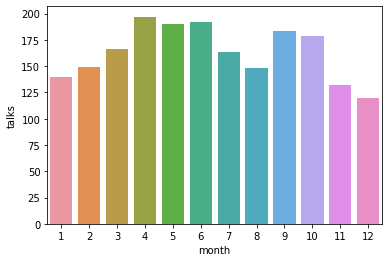

In [9]:
data['month'] = data['published_date'].dt.month

month_df = pd.DataFrame(data['month'].value_counts()).reset_index()
month_df.columns = ['month', 'talks']

month_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
sns.barplot(x='month', y='talks', data=month_df, order=month_order)

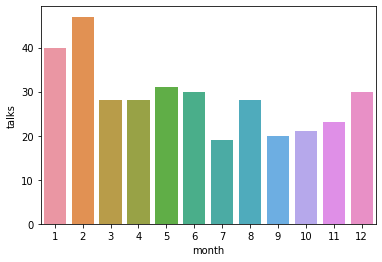

In [10]:
df_x = data[data['event_y'].str.contains('TEDx')]
x_month_df = pd.DataFrame(df_x['month'].value_counts().reset_index())
x_month_df.columns = ['month', 'talks']

month_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
sns.barplot(x='month', y='talks', data=x_month_df, order=month_order)

### Number of talks per year

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



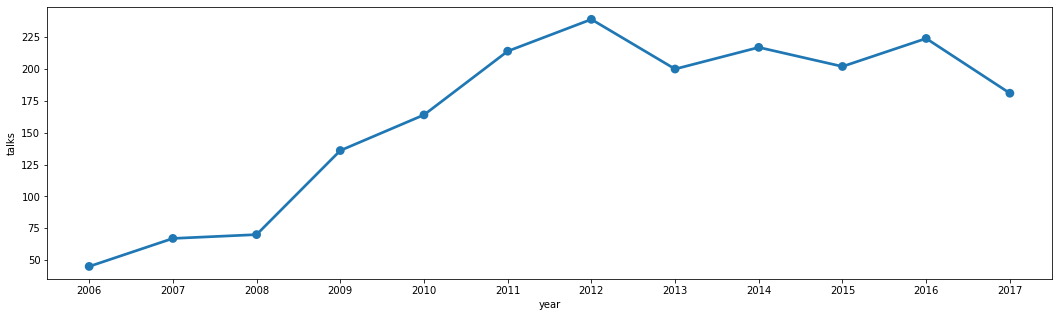

In [11]:
data['year'] = data['published_date'].dt.year

year_df = pd.DataFrame(data['year'].value_counts().reset_index())
year_df.columns = ['year', 'talks']

year_df.sort_values(by='year', inplace=True)



plt.figure(figsize=(18,5))
sns.pointplot(x='year', y='talks', data=year_df)

plt.show()

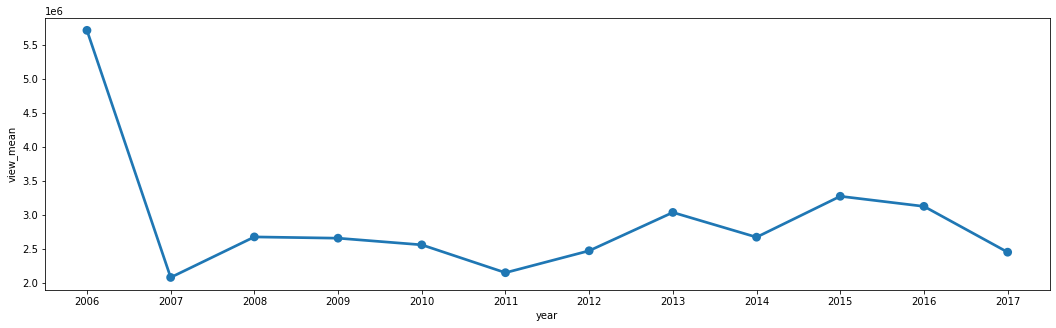

In [12]:
view_year_df = pd.DataFrame(data.groupby('year')['view_count'].mean().reset_index())
view_year_df.columns = ['year', 'view_mean']

view_year_df.sort_values(by='year', inplace=True)

plt.figure(figsize=(18,5))

sns.pointplot(x='year', y='view_mean', data=view_year_df)
plt.show()

In [13]:
talk_view_df = year_df
talk_view_df['view_mean'] = view_year_df['view_mean']

talk_view_df['talks'].corr(talk_view_df['view_mean'])

0.13106087816043244

It is observed from above that there is no correlation between the number of talks per year and the number of views during that duration

### Views per Event

In [14]:
# group the data by the event and calculate the sum
sums = data.groupby("event_y")["view_count"].agg(["sum","mean","count"]).sort_values("sum",ascending=False) .nlargest(10,"sum")

In [15]:
text = round(sums["sum"]/1000000,2)
lis = [str(s)+" M" for s in text]
fig = px.bar(sums,x=sums.index,y="sum",
           labels={"y":"Sum & mean & number of talks","x":"event"},
      title="Total number of views for event",
       color_discrete_sequence=["#192A36"],
           text=lis
      )
fig.show()

### 10 highest occupation which made a tedtalk

In [16]:
# get the value counts of each occupation
s = data["speaker_occupation"].value_counts().sort_values(ascending=False).nlargest(10)

fig = px.pie(names=s.index,values=s.values,labels={
    "names":"the occupation ",
    "values":"number of talks "
},
title="The highest 10 occupation with the number of talks",
       hole=.5
      )

In [17]:
fig.show()

In [18]:
fig.write_html('../results/occupation_talks_pie.html')

This result must be taken with a pinch of salt as a considerable number of speakers identify themselves with multiple professions (for example, writer/entrepreneur). Performing an analysis taking this into consideraion is left as an exercise to the reader.

### Do some professions tend to attract a larger number of viewers?

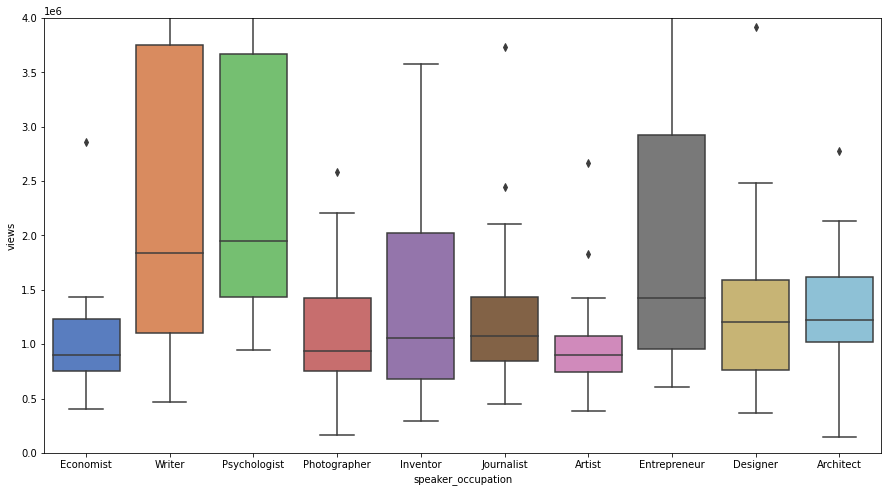

In [19]:
occupation_df = data.groupby('speaker_occupation').count().reset_index()[['speaker_occupation', 'comments']]
occupation_df.columns = ['occupation', 'appearances']
occupation_df = occupation_df.sort_values('appearances', ascending=False)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='speaker_occupation', y='views', data=data[data['speaker_occupation'].isin(occupation_df.head(10)['occupation'])], palette="muted", ax =ax)
ax.set_ylim([0, 0.4e7])
plt.show()

On average, out of the top 10 most popular professions, Psychologists tend to garner the most views. Writers have the greatest range of views between the first and the third quartile..

### Top Ratings

### Tags/Themes

### Duration 

In [20]:
data['duration'] = data['duration_y'] / 60
data['duration'].describe()

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count    1959.000000
mean       13.608746
std         5.367578
min         2.383333
25%         9.808333
50%        14.050000
75%        17.283333
max        60.133333
Name: duration, dtype: float64

In [21]:
data[["speaker__name", "title", "event_y", "duration"]].sort_values("duration").head(10)

speaker__name                                 title  \
221         Yves Béhar      A supercharged motorcycle design   
921      Paolo Cardini  Forget multitasking, try monotasking   
566        Terry Moore                 How to tie your shoes   
1004    Malcolm London         "High School Training Ground"   
809       Damian Palin         Mining minerals from seawater   
299   Cameron Sinclair         The refugees of boom-and-bust   
949         Lee Cronin               Print your own medicine   
352       Derek Sivers               How to start a movement   
142        Dean Ornish          Your genes are not your fate   
430       Derek Sivers           Keep your goals to yourself   

                  event_y  duration  
221               TED2009  2.383333  
921        TEDGlobal 2012  2.866667  
566               TED2005  2.983333  
1004  TED Talks Education  3.000000  
809               TED2012  3.016667  
299        TEDGlobal 2009  3.083333  
949        TEDGlobal 2012  3.100000  
352               TED2010  3.150000  
142               TED2008  3.200000  
430        TEDGlobal 2010  3.250000

view_count  comments  duration
view_count    1.000000  0.455397  0.092853
comments      0.455397  1.000000  0.186907
duration      0.092853  0.186907  1.000000

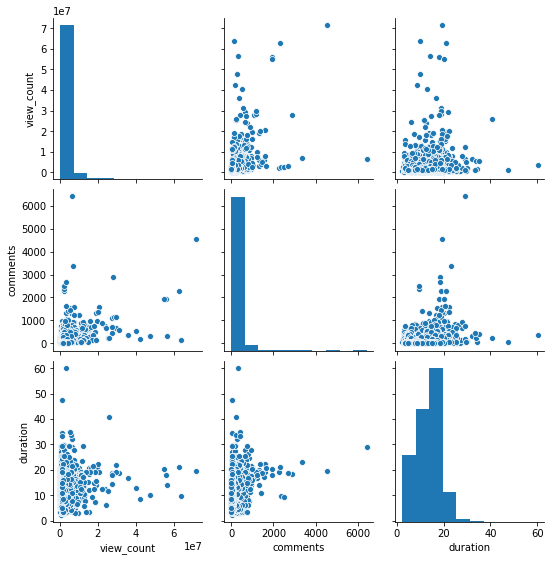

In [22]:
sns.pairplot(data=data, vars=["view_count", "comments", "duration"])
display(data[["view_count", "comments", "duration"]].corr())

We observe from the above plot that the duration of the talks does not have a correlation with either the view count or the number of comments. Let's have a look if it has any correlation with the number of likes and dislikes

In [23]:
#Duration vs Likes and Dislikes

In [24]:
# Duration vs Occupation

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



technology       0.035710
science          0.030231
global issues    0.025149
culture          0.024224
TEDx             0.021650
design           0.018086
business         0.017492
innovation       0.013399
health           0.013201
society          0.013069
Name: tags, dtype: float64

0.21221122112211221

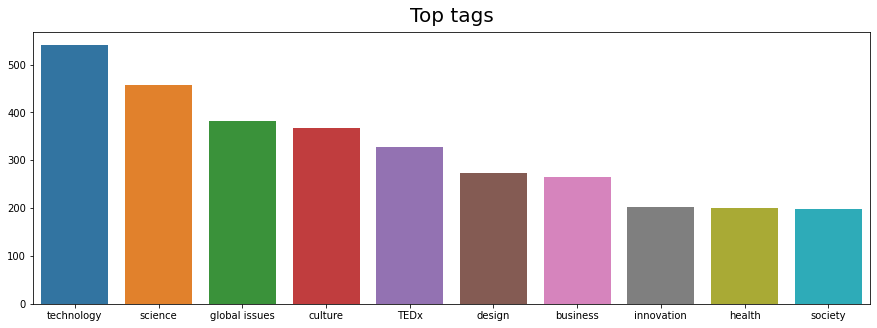

In [25]:
data["tags"] = data["tags"].apply(lambda x: ast.literal_eval(x))

tags = data["tags"].explode().value_counts().head(10)
display(data["tags"].explode().value_counts(normalize=True).head(10))
display(data["tags"].explode().value_counts(normalize=True).head(10).sum())
plt.figure(figsize=(15,5))
ax = sns.barplot(x=tags.index, y=tags.values)
ax.set_title("Top tags", pad=10, fontdict={'fontsize': 20})
plt.show()

In [ ]:
data.

Most talks seem to be coming Technology category, followed by Science, Global issues and Culture.
Still, top 10 tags seem to account for only 21% of the total categories.

In [26]:
data['dis_quo'] = data['comments']/data['views']

data[['title', 'speaker__name','views', 'comments', 'dis_quo', 'published_date']].sort_values('dis_quo', ascending=False).head(10)

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



title      speaker__name    views  \
74                           Militant atheism    Richard Dawkins  4374792   
576              Taking imagination seriously     Janet Echelman  1832930   
483                      On reading the Koran    Lesley Hazleton  1847256   
510              Curating humanity's heritage  Elizabeth Lindsey   439180   
1256        How do you explain consciousness?     David Chalmers  2162764   
358              The danger of science denial    Michael Specter  1838628   
805          A new way to stop identity theft        David Birch   174326   
214   What comes after An Inconvenient Truth?            Al Gore   775430   
413             Superheroes inspired by Islam     Naif Al-Mutawa   819361   
728                      The true cost of oil         Garth Lenz   792779   

      comments   dis_quo      published_date  
74        6404  0.001464 2007-04-16 02:07:00  
576       2492  0.001360 2011-06-07 23:36:00  
483       2374  0.001285 2011-01-04 15:33:00  
510        555  0.001264 2011-02-23 16:25:00  
1256      2673  0.001236 2014-07-14 15:08:04  
358       2272  0.001236 2010-04-12 09:38:00  
805        208  0.001193 2012-06-03 14:08:36  
214        846  0.001091 2009-05-07 01:00:00  
413        804  0.000981 2010-07-20 09:08:00  
728        775  0.000978 2012-02-18 14:54:08

Discard audio files with more than one speaker.

In [27]:
print(data['languages'][data['languages'] == 0].count())
data[data['languages'] == 0]['description']

20


197     Eric Lewis, an astonishingly talented crossove...
267     Vishal Vaid and his band explore a traditional...
389     This haunting, intimate performance by Europea...
669     The next big shift is now, and it's not what y...
683     Real narratives are complicated: Africa isn't ...
699     We don't just need better laws -- we need bett...
700     How do you measure a nebula? With a brain scan...
703     Kirk Sorensen shows us the liquid fuel thorium...
707     Scott Rickard set out to engineer the ugliest ...
724     Singer Inara George and guitarist Mike Andrews...
729     How often do you see the true beauty of the ni...
735     Were you the favorite child, the wild child or...
748     Architecture can bring people together, or div...
753     Jer Thorp creates beautiful data visualization...
784     Rick Guidotti is a fashion photographer with a...
789     The revolution that made music more marketable...
796     An average teaspoon of ocean water contains fi...
850     Giles 

Some of these cases are dance or music performance but others are talks in one language. They all will be considered with one idiom.

In [28]:
data['languages'] = data['languages'].replace(0, 1)

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



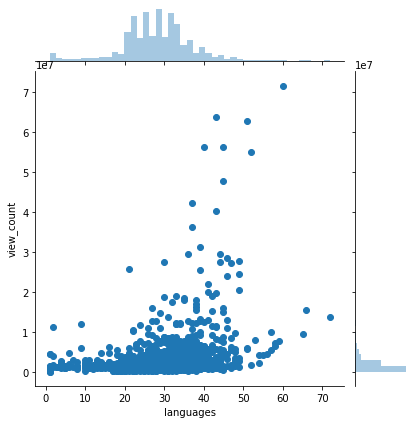

In [29]:
sns.jointplot(x='languages', y='view_count', data=data)
plt.show()

### Understanding Ratings

In [30]:
rating_names = set()
for index, row in data.iterrows():
    rating = ast.literal_eval(row['ratings'])
    for item in rating:
        rating_names.add(item['name'])
    
print(rating_names)

{'OK', 'Beautiful', 'Ingenious', 'Fascinating', 'Jaw-dropping', 'Courageous', 'Unconvincing', 'Informative', 'Persuasive', 'Longwinded', 'Inspiring', 'Confusing', 'Funny', 'Obnoxious'}


In [31]:
rating_data = defaultdict(list)
for index, row in data.iterrows():
    rating = ast.literal_eval(row['ratings'])
    rating_data['Talk_ID'].append(row['talk__id'])
    names = set()
    for item in rating:
        rating_data[item['name']].append(item['count'])
        names.add(item['name'])

rating_data = pd.DataFrame(rating_data)

rating_data.head()

Talk_ID  Funny  Beautiful  Ingenious  Courageous  Longwinded  Confusing  \
0       66  19645       4573       6073        3253         387        242   
1        1    544         58         56         139         113         62   
2        7    964         60        183          45          78         27   
3       53     59        291        105         760          53         32   
4       96   1102        706        397         721         285        301   

   Informative  Fascinating  Unconvincing  Persuasive  Jaw-dropping    OK  \
0         7346        10581           300       10704          4439  1174   
1          443          132           258         268           116   203   
2          395          166           104         230            54   146   
3          380          132            36         460           230    85   
4         1038         1350           377        2423           669   441   

   Obnoxious  Inspiring  
0        209      24924  
1        131        413  
2        142        230  
3         35       1070  
4        335       5211

The values in each column represent the number of votes the talk received for each rating.

In [32]:
#Adding a column 'total' which is the total of votes for each talk. 
rating_data['total'] = rating_data.sum(axis = 1)
rating_data = rating_data.sort_values('total', ascending=False)  

In [33]:
def column_percentage(column):
    return (column/rating_data['total'])*100

rating_data.loc[:, (rating_data.columns != 'total') &  (rating_data.columns !='Talk_ID')] = \
    rating_data.loc[:, (rating_data.columns != 'total') &  (rating_data.columns !='Talk_ID')].apply(column_percentage)

print(rating_data.head())

     Talk_ID      Funny  Beautiful  Ingenious  Courageous  Longwinded  \
0         66  20.917629   4.869245   6.466417    3.463734    0.412070   
123      229   1.362598  13.311423   1.732164   11.061585    0.561402   
888     1569   1.388868   4.785525   2.114397    9.335623    0.500466   
480     1042   8.548757  12.994110   1.789921   13.547120    0.463024   
373      848   0.676766   2.845888   5.922571    2.014681    0.676766   

     Confusing  Informative  Fascinating  Unconvincing  Persuasive  \
0     0.257677     7.821883    11.266451      0.319434   11.397419   
123   0.407651     7.659322    20.378311      0.775806    2.403588   
888   0.291692    14.491316    16.451723      0.496024    9.205324   
480   0.253599     7.462369     7.588351      0.381217    5.742801   
373   0.194353    11.452965    12.910615      1.613827   15.348708   

     Jaw-dropping        OK  Obnoxious  Inspiring  total  
0        4.726564  1.250053   0.222539  26.538609  93916  
123     14.760064  0.8

In [34]:
count_talks = defaultdict(list)
for rating in rating_data.columns:
    if (rating != 'Talk_ID') & (rating != 'total'):
        count_talks['rating'].append(rating) 
        count_talks['count'].append(rating_data[rating_data[rating] >0][rating].count())

In [35]:
count_talks

defaultdict(list,
            {'rating': ['Funny',
              'Beautiful',
              'Ingenious',
              'Courageous',
              'Longwinded',
              'Confusing',
              'Informative',
              'Fascinating',
              'Unconvincing',
              'Persuasive',
              'Jaw-dropping',
              'OK',
              'Obnoxious',
              'Inspiring'],
             'count': [1911,
              1956,
              1958,
              1953,
              1911,
              1876,
              1953,
              1958,
              1923,
              1959,
              1958,
              1951,
              1866,
              1959]})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

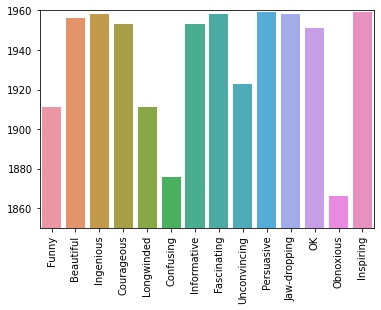

In [36]:
sns.barplot(x="rating", y="count", data=count_talks)
plt.ylim(1850, 1960)
plt.xticks(rotation='vertical')

The total number of talks is 1959. Some ratings seem to be used in all (or almost all) the talks, such as Inspiring, Ingenious, Persuasive, Jaw-dropping, and Fascinating. The positive ratings are very frequently used, while the negative ones (Obnoxious, Longwinded, Confusing and Unconvincing) are less present in the Talks.
In general all the ratings, positives and negatives, were voted in most of the talks. That shows how peoples opinion may diverge a lot.

In [37]:
rating_data

Talk_ID      Funny  Beautiful  Ingenious  Courageous  Longwinded  \
0         66  20.917629   4.869245   6.466417    3.463734    0.412070   
123      229   1.362598  13.311423   1.732164   11.061585    0.561402   
888     1569   1.388868   4.785525   2.114397    9.335623    0.500466   
480     1042   8.548757  12.994110   1.789921   13.547120    0.463024   
373      848   0.676766   2.845888   5.922571    2.014681    0.676766   
..       ...        ...        ...        ...         ...         ...   
51        48   0.484653   0.646204  14.378029    0.646204    5.008078   
37        57   0.179856   1.079137  22.661871    1.978417    3.237410   
88       154   0.186567   1.119403   5.783582    1.492537    2.985075   
31        75   0.196078   2.156863   8.235294   10.392157    6.078431   
63        81   2.360515  26.394850   3.648069    4.721030    0.643777   

     Confusing  Informative  Fascinating  Unconvincing  Persuasive  \
0     0.257677     7.821883    11.266451      0.319434   11.397419   
123   0.407651     7.659322    20.378311      0.775806    2.403588   
888   0.291692    14.491316    16.451723      0.496024    9.205324   
480   0.253599     7.462369     7.588351      0.381217    5.742801   
373   0.194353    11.452965    12.910615      1.613827   15.348708   
..         ...          ...          ...           ...         ...   
51   15.185784    15.831987    13.570275      3.554120    1.938611   
37    0.719424    20.683453    13.309353      3.597122    4.856115   
88    0.186567    18.283582     6.156716      2.052239    6.343284   
31    2.156863    19.803922     5.294118      0.784314   10.000000   
63    1.502146     0.429185     8.154506      4.291845    1.072961   

     Jaw-dropping        OK  Obnoxious  Inspiring  total  
0        4.726564  1.250053   0.222539  26.538609  93916  
123     14.760064  0.897114   0.502158  23.863797  70894  
888      5.309682  1.671676   0.229504  31.405008  67537  
480      3.435864  0.818063   0.184882  35.085079  61120  
373      4.614157  2.327034   0.510178  37.419959  57627  
..            ...       ...        ...        ...    ...  
51       3.715670  8.562197   0.969305   7.754443    619  
37       3.237410  4.136691   1.438849   8.633094    556  
88       0.932836  2.985075   0.559701  22.201493    536  
31       0.588235  4.901961   0.784314  13.921569    510  
63       4.721030  6.652361   2.789700  15.236052    466  

[1959 rows x 16 columns]

In [38]:
rating_data[['Funny', 'Beautiful', 'Ingenious', 'Courageous',
       'Longwinded', 'Confusing', 'Informative', 'Fascinating', 'Unconvincing',
       'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring']].apply(np.argmax, axis = 1)

0      13
123    13
888    13
480    13
373    13
       ..
51      6
37      2
88     13
31      6
63      1
Length: 1959, dtype: int64

In [39]:
len(['Funny', 'Beautiful', 'Ingenious', 'Courageous',
       'Longwinded', 'Confusing', 'Informative', 'Fascinating', 'Unconvincing',
       'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring'])

14

In [40]:
rating_values = rating_data.loc[:, (rating_data.columns != 'total') &  (rating_data.columns !='Talk_ID')] 
rating_data['main_rating'] = rating_values.apply(np.argmax, axis = 1)

rating_data['main_rating'].shape

(1959,)

In [41]:
cols = ['Funny', 'Beautiful', 'Ingenious', 'Courageous',
       'Longwinded', 'Confusing', 'Informative', 'Fascinating', 'Unconvincing',
       'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring']

# Error Check

https://www.kaggle.com/anandaribeiro/understanding-ted-talks-ratings

([<matplotlib.axis.XTick at 0x7fbda466aeb8>,
 [Text(0, 0, 'Courageous'),
  Text(0, 0, 'Longwinded'),
  Text(0, 0, 'Confusing'),
  Text(0, 0, 'Informative'),
  Text(0, 0, 'Jaw-dropping'),
  Text(0, 0, 'OK'),
  Text(0, 0, 'Beautiful'),
  Text(0, 0, 'Ingenious'),
  Text(0, 0, 'Persuasive'),
  Text(0, 0, 'Fascinating'),
  Text(0, 0, 'Unconvincing'),
  Text(0, 0, 'Obnoxious'),
  Text(0, 0, 'Inspiring'),
  Text(0, 0, 'Funny')])

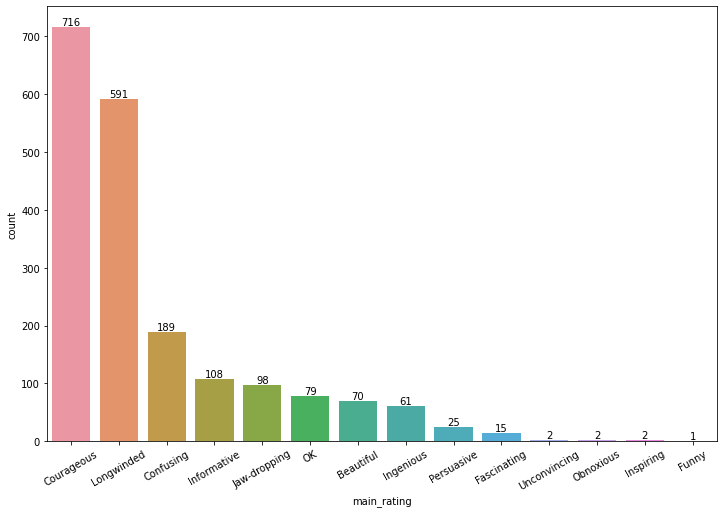

In [42]:
label_order = rating_data['main_rating'].value_counts().sort_values(ascending = False).index
xticks = [x for _,x in sorted(zip(list(label_order), cols))]
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(x = 'main_rating', data = rating_data, order = label_order)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:d}'.format(height),
            ha="center") 
plt.xticks(list(range(14)), xticks, rotation=30)

Text(0, 0.5, 'Percentage of Votes')

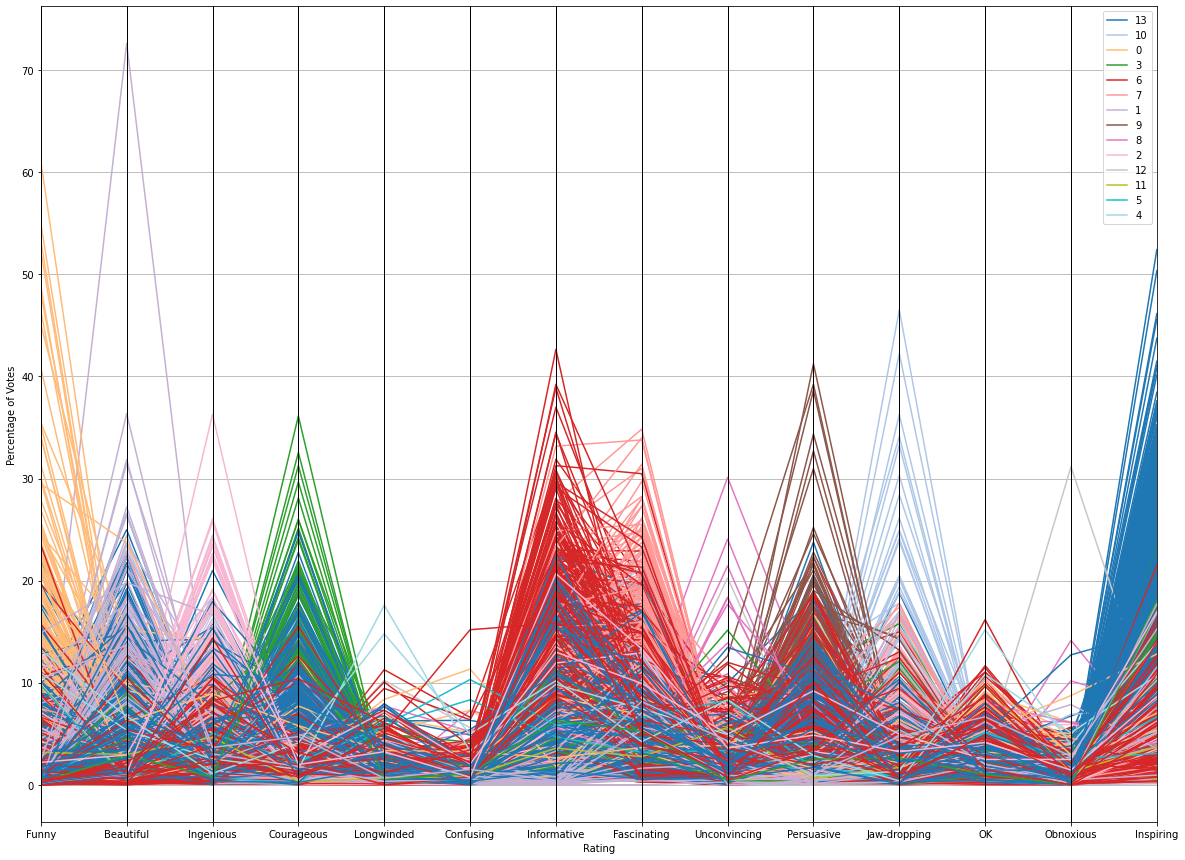

In [43]:
rating_values_updated = rating_data.loc[:, (rating_data.columns != 'total') &  (rating_data.columns !='Talk_ID')]
plt.figure(figsize=(20,15))
parallel_coordinates(rating_values_updated, 'main_rating', colormap=plt.get_cmap("tab20"))
plt.xlabel("Rating")
plt.ylabel("Percentage of Votes")

In [44]:
rating_data

Talk_ID      Funny  Beautiful  Ingenious  Courageous  Longwinded  \
0         66  20.917629   4.869245   6.466417    3.463734    0.412070   
123      229   1.362598  13.311423   1.732164   11.061585    0.561402   
888     1569   1.388868   4.785525   2.114397    9.335623    0.500466   
480     1042   8.548757  12.994110   1.789921   13.547120    0.463024   
373      848   0.676766   2.845888   5.922571    2.014681    0.676766   
..       ...        ...        ...        ...         ...         ...   
51        48   0.484653   0.646204  14.378029    0.646204    5.008078   
37        57   0.179856   1.079137  22.661871    1.978417    3.237410   
88       154   0.186567   1.119403   5.783582    1.492537    2.985075   
31        75   0.196078   2.156863   8.235294   10.392157    6.078431   
63        81   2.360515  26.394850   3.648069    4.721030    0.643777   

     Confusing  Informative  Fascinating  Unconvincing  Persuasive  \
0     0.257677     7.821883    11.266451      0.319434   11.397419   
123   0.407651     7.659322    20.378311      0.775806    2.403588   
888   0.291692    14.491316    16.451723      0.496024    9.205324   
480   0.253599     7.462369     7.588351      0.381217    5.742801   
373   0.194353    11.452965    12.910615      1.613827   15.348708   
..         ...          ...          ...           ...         ...   
51   15.185784    15.831987    13.570275      3.554120    1.938611   
37    0.719424    20.683453    13.309353      3.597122    4.856115   
88    0.186567    18.283582     6.156716      2.052239    6.343284   
31    2.156863    19.803922     5.294118      0.784314   10.000000   
63    1.502146     0.429185     8.154506      4.291845    1.072961   

     Jaw-dropping        OK  Obnoxious  Inspiring  total  main_rating  
0        4.726564  1.250053   0.222539  26.538609  93916           13  
123     14.760064  0.897114   0.502158  23.863797  70894           13  
888      5.309682  1.671676   0.229504  31.405008  67537           13  
480      3.435864  0.818063   0.184882  35.085079  61120           13  
373      4.614157  2.327034   0.510178  37.419959  57627           13  
..            ...       ...        ...        ...    ...          ...  
51       3.715670  8.562197   0.969305   7.754443    619            6  
37       3.237410  4.136691   1.438849   8.633094    556            2  
88       0.932836  2.985075   0.559701  22.201493    536           13  
31       0.588235  4.901961   0.784314  13.921569    510            6  
63       4.721030  6.652361   2.789700  15.236052    466            1  

[1959 rows x 17 columns]

In [45]:
ted_basic_info = data[['talk__id', 'title', 'duration','comments','view_count','languages']]
ted_basic_info.columns = ['Talk_ID','title', 'duration','comments','view_count','languages']

In [46]:
rating_and_basic = ted_basic_info.merge(rating_data, how = 'left', on = ['Talk_ID'])

(0.0, 10000000.0)

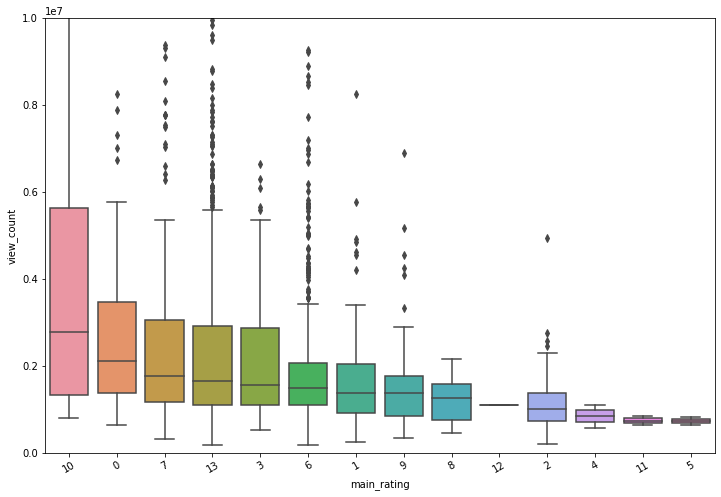

In [47]:
list_ordered_by_median = rating_and_basic.groupby('main_rating')['view_count'].median().sort_values(ascending = False).index

f, ax = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x="main_rating", y="view_count", data=rating_and_basic, order = list_ordered_by_median)
plt.xticks(rotation=30)
plt.ylim((0,10000000))

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Text(0.5, 1.0, 'Heatmap of Correlation between Features')

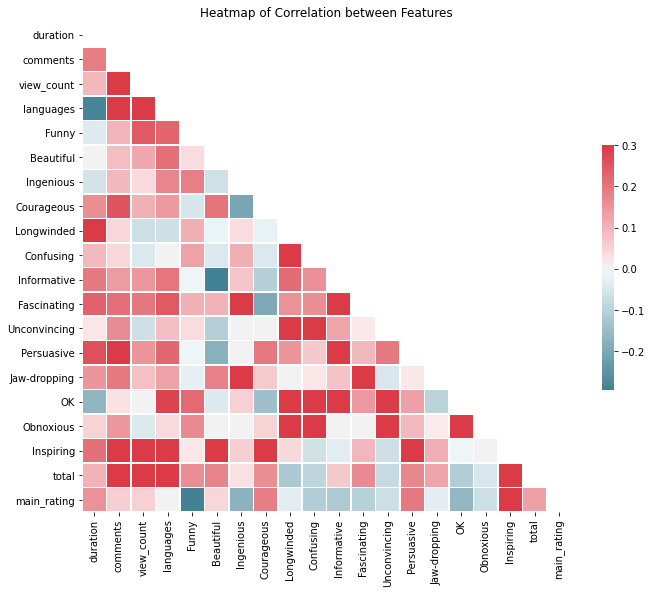

In [48]:
#Features to remove from the plot:
features_to_remove = ['Talk_ID', 'title']
corr = rating_and_basic.drop(features_to_remove, axis = 1).corr() 
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of Correlation between Features')

According to the heatmap, there are two strong negative correlations:

- duration and languages. That was already observed in the bloxplots analyses.
- Informative and Beautiful. That shows that the talks are voted for one or another of these ratings. They are not usually used together.

And there are many positive correlations. Some interesting examples:

- Confusing, Unconvincing, OK, Longwinded and Obnoxious. All the negative ratings are usually voted together.
- comments, views, languages and the total of votes. These features are positively correlated. 
- This behavior already appeared in previous analyses, except for the variable languages.
- Longwinded and duration. As expected, according to previous analyses.
- Jaw-dropping, Fascinating and Ingenious. These ratings are different but it seems they are frequently used together by the viewers.
- Persuasive and comments. It was expected from the boxplots analysis. This relation will be explored below.

### Tags

In [49]:
tags_data = defaultdict(list)
for index, row in data.iterrows():
    themes = row['tags']
    for item in themes:
        tags_data['Talk_ID'].append(row['talk__id'])
        tags_data['tags'].append(item)

tags_data = pd.DataFrame(tags_data)

print(len(tags_data))
print(len(tags_data['tags'].unique()))
tags_data.head()

15150
413


Talk_ID        tags
0       66    children
1       66  creativity
2       66     culture
3       66       dance
4       66   education

The total number of tags used is 15150. However there are only 413 unique tags.

In [50]:
data.title

0                             Do schools kill creativity?
1                             Averting the climate crisis
2                                        Simplicity sells
3                                     Greening the ghetto
4                                    Why we do what we do
                              ...                        
1954    What we're missing in the debate about immigra...
1955                      The most Martian place on Earth
1956    What intelligent machines can learn from a sch...
1957         A black man goes undercover in the alt-right
1958    How a video game might help us build better ci...
Name: title, Length: 1959, dtype: object

### Popular TED Speakers 

In [51]:
speaker_df = data.groupby('speaker__name').count().reset_index()[['speaker__name', 'comments']]
speaker_df.columns = ['speaker__name', 'appearances']
speaker_df = speaker_df.sort_values('appearances', ascending=False)
speaker_df.head(10)

speaker__name  appearances
833          Juan Enriquez            6
1341                 Rives            5
841        Julian Treasure            5
805         Jonathan Haidt            4
1005         Marco Tempest            4
202             Bill Gates            4
597           Hans Rosling            4
932        Lawrence Lessig            4
658   Jacqueline Novogratz            4
334             Dan Ariely            4

### Occupation Wise Rating

### Computing Likes, Dislikes and Scores

In [56]:
pos_labels = ['Fascinating', 'Ingenious','Jaw-dropping'] 
neg_labels = ['Longwinded','Unconvincing', 'OK']

for index, row in data.iterrows():
    x = ast.literal_eval(row['ratings'])
    likes = 0
    dislikes = 0
    for i in x:
        if i['name'] in pos_labels:
#             print('likes', likes)
            likes += i['count']
        elif i['name'] in neg_labels:
            dislikes += i['count']
    data.loc[index, 'likes'] = likes
    data.loc[index, 'dislikes'] = dislikes

/home/mounika.k/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mounika.k/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
data['scores'] = (data['comments'] + data['likes'] + data['dislikes'])/data['views']

/home/mounika.k/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
data.shape

(1959, 27)

### Speech Patterns Between the Different Rating Types

In [61]:
path = '/ssd_scratch/users/mounika.k/ted_audio_features_final/'

In [62]:
rfiles = os.listdir(path + 'rmse/')

rmse_data = []
for file in rfiles:
    rmse_data.append(np.load(path + 'rmse/' + file))
rmse_arr = np.vstack(rmse_data)
rmse_arr.shape

(1836, 12920)

In [64]:
rmse_mean = np.mean(rmse_arr, axis=1)

In [65]:
vcfiles = os.listdir(path + 'vc/')
vc_data = []
for file in vcfiles:
    vc_data.append(np.load(path + 'vc/' + file))
vc_arr = np.vstack(vc_data)
vc_arr.shape

(1836, 5)

In [66]:
vc_df = pd.DataFrame(vc_arr, columns=['pausedur', 'speakingrate', 'articulationrate', 'asd', 'unvoicedcount'])

In [68]:
vc_df['rmse_mean'] = list(rmse_mean)

In [71]:
files = [f.replace('.npy', '') for f in rfiles]

In [91]:
data = data.astype({"talk__id": 'str'})

In [92]:
sub_df = data[data['talk__id'].isin(files)]

In [101]:
vc_df['talk_id'] = files

In [102]:
sub_df.columns

Index(['speaker__id', 'comments', 'transcript', 'views', 'ratings',
       'speaker_occupation', 'languages', 'tags', 'speaker__is_published',
       'is_talk_featured', 'speaker__name', 'duration_y', 'label', 'title',
       'talk__id', 'view_count', 'published_date', 'description', 'event_y',
       'interaction', 'month', 'year', 'duration', 'dis_quo', 'likes',
       'dislikes', 'scores'],
      dtype='object')

Ignoring ratings for now.

In [173]:
sub_df.speaker_occupation.value_counts()

Writer                                  37
Journalist                              25
Artist                                  23
Psychologist                            23
Designer                                22
                                        ..
Neuroscientist, writer, entrepreneur     1
Open-source engineer and artist          1
Pediatric anesthesiologist               1
Transhumanist                            1
Artificial life researcher               1
Name: speaker_occupation, Length: 1143, dtype: int64

In [108]:
cols = ['comments', 'views', 'speaker_occupation', 'label', 'talk__id', 'view_count', 'interaction', 'dis_quo', 'likes', 'dislikes', 'scores']

In [109]:
ted_speech_df = pd.merge(sub_df[cols], vc_df, left_on='talk__id', right_on='talk_id')

In [110]:
ted_speech_df

comments     views                           speaker_occupation  label  \
0         4553  47227110                              Author/educator    1.0   
1          265   3200520                             Climate advocate    0.0   
2          124   1636292                         Technology columnist    1.0   
3          200   1697550           Activist for environmental justice    1.0   
4          672  20685401  Life coach; expert in leadership psychology    1.0   
...        ...       ...                                          ...    ...   
1831        17    450430                                   Journalist    1.0   
1832         6    417470                               Astrobiologist    1.0   
1833        10    375647                            Robotics engineer    1.0   
1834        32    419309                          Public intellectual    1.0   
1835         8    391721                                Game designer    0.0   

     talk__id  view_count  interaction   dis_quo    likes  dislikes    scores  \
0          66    71557707      10373.0  0.000096  21093.0    1861.0  0.000582   
1           1     3626549      12077.0  0.000083    304.0     574.0  0.000357   
2           7     1993146      13196.0  0.000076    403.0     328.0  0.000523   
3          53     2910867       8488.0  0.000118    467.0     174.0  0.000495   
4          96    29436879      30782.0  0.000032   2416.0    1103.0  0.000203   
...       ...         ...          ...       ...      ...       ...       ...   
1831     2879     1201578      26496.0  0.000038     44.0      15.0  0.000169   
1832     2869     1223962      69578.0  0.000014     46.0      14.0  0.000158   
1833     2870     1298325      37565.0  0.000027     44.0       5.0  0.000157   
1834     2887     4600702      13103.0  0.000076     83.0      14.0  0.000308   
1835     2882     1508364      48965.0  0.000020     26.0      41.0  0.000191   

         pausedur  speakingrate  articulationrate       asd  unvoicedcount  \
0     1255.627624      3.809265          4.218563  0.237048            3.0   
1      962.325746      3.012043          3.739679  0.267403           15.0   
2      972.312685      3.662931          3.926790  0.254661           23.0   
3     1038.067460      3.885016          4.023853  0.248518           11.0   
4     1160.699297      4.508923          5.106969  0.195811           20.0   
...           ...           ...               ...       ...            ...   
1831   592.874971      3.308832          4.362520  0.229225           27.0   
1832   435.121501      3.653118          4.575251  0.218567           10.0   
1833   767.310562      3.919800          4.841662  0.206541           10.0   
1834  1262.811297      3.622595          4.558674  0.219362           20.0   
1835   637.335379      3.598945          4.668737  0.214191           17.0   

      rmse_mean talk_id  
0      0.073813      66  
1      0.150411       1  
2      0.175868       7  
3      0.248831      53  
4      0.138598      96  
...         ...     ...  
1831   0.067967    2879  
1832   0.080002    2869  
1833   0.079495    2870  
1834   0.073205    2887  
1835   0.069356    2882  

[1836 rows x 18 columns]

In [111]:
ted_speech_df['dislike_like_ratio'] = ted_speech_df['dislikes'] / ted_speech_df['likes']

In [115]:
ted_speech_df

comments     views                           speaker_occupation  label  \
0         4553  47227110                              Author/educator    1.0   
1          265   3200520                             Climate advocate    0.0   
2          124   1636292                         Technology columnist    1.0   
3          200   1697550           Activist for environmental justice    1.0   
4          672  20685401  Life coach; expert in leadership psychology    1.0   
...        ...       ...                                          ...    ...   
1831        17    450430                                   Journalist    1.0   
1832         6    417470                               Astrobiologist    1.0   
1833        10    375647                            Robotics engineer    1.0   
1834        32    419309                          Public intellectual    1.0   
1835         8    391721                                Game designer    0.0   

     talk__id  view_count  interaction   dis_quo    likes  dislikes    scores  \
0          66    71557707      10373.0  0.000096  21093.0    1861.0  0.000582   
1           1     3626549      12077.0  0.000083    304.0     574.0  0.000357   
2           7     1993146      13196.0  0.000076    403.0     328.0  0.000523   
3          53     2910867       8488.0  0.000118    467.0     174.0  0.000495   
4          96    29436879      30782.0  0.000032   2416.0    1103.0  0.000203   
...       ...         ...          ...       ...      ...       ...       ...   
1831     2879     1201578      26496.0  0.000038     44.0      15.0  0.000169   
1832     2869     1223962      69578.0  0.000014     46.0      14.0  0.000158   
1833     2870     1298325      37565.0  0.000027     44.0       5.0  0.000157   
1834     2887     4600702      13103.0  0.000076     83.0      14.0  0.000308   
1835     2882     1508364      48965.0  0.000020     26.0      41.0  0.000191   

         pausedur  speakingrate  articulationrate       asd  unvoicedcount  \
0     1255.627624      3.809265          4.218563  0.237048            3.0   
1      962.325746      3.012043          3.739679  0.267403           15.0   
2      972.312685      3.662931          3.926790  0.254661           23.0   
3     1038.067460      3.885016          4.023853  0.248518           11.0   
4     1160.699297      4.508923          5.106969  0.195811           20.0   
...           ...           ...               ...       ...            ...   
1831   592.874971      3.308832          4.362520  0.229225           27.0   
1832   435.121501      3.653118          4.575251  0.218567           10.0   
1833   767.310562      3.919800          4.841662  0.206541           10.0   
1834  1262.811297      3.622595          4.558674  0.219362           20.0   
1835   637.335379      3.598945          4.668737  0.214191           17.0   

      rmse_mean talk_id  dislike_like_ratio  
0      0.073813      66            0.088228  
1      0.150411       1            1.888158  
2      0.175868       7            0.813896  
3      0.248831      53            0.372591  
4      0.138598      96            0.456540  
...         ...     ...                 ...  
1831   0.067967    2879            0.340909  
1832   0.080002    2869            0.304348  
1833   0.079495    2870            0.113636  
1834   0.073205    2887            0.168675  
1835   0.069356    2882            1.576923  

[1836 rows x 19 columns]

In [155]:
tgt_cols = ['comments', 'views', 'label',
       'view_count', 'interaction', 'dis_quo', 'likes', 'dislikes', 'scores',
       'pausedur', 'speakingrate', 'articulationrate', 'asd', 'unvoicedcount',
       'rmse_mean']

In [165]:
data.ratings

0       [{'id': 7, 'name': 'Funny', 'count': 19645}, {...
1       [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...
2       [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...
3       [{'id': 3, 'name': 'Courageous', 'count': 760}...
4       [{'id': 7, 'name': 'Funny', 'count': 1102}, {'...
                              ...                        
1954    [{'id': 3, 'name': 'Courageous', 'count': 24},...
1955    [{'id': 22, 'name': 'Fascinating', 'count': 32...
1956    [{'id': 1, 'name': 'Beautiful', 'count': 14}, ...
1957    [{'id': 11, 'name': 'Longwinded', 'count': 3},...
1958    [{'id': 21, 'name': 'Unconvincing', 'count': 2...
Name: ratings, Length: 1959, dtype: object

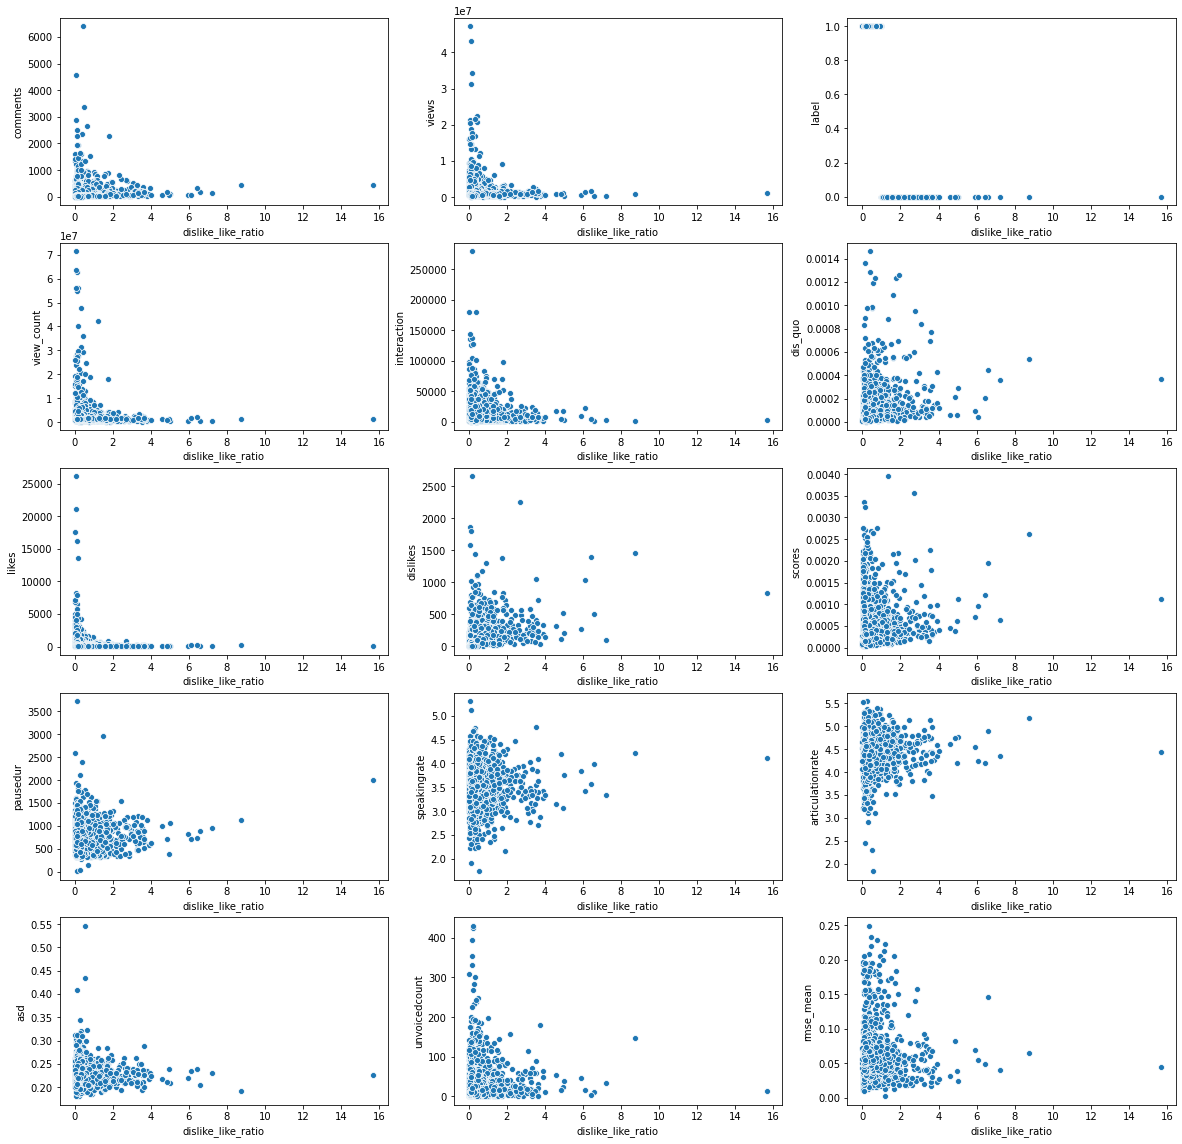

In [157]:
a = 5
b = 3
c = 1
fig = plt.figure(figsize=(20, 20))
for row_idx, col in enumerate(tgt_cols):
    plt.subplot(a, b, c)
    sns.scatterplot(x=ted_speech_df['dislike_like_ratio'], y=ted_speech_df[col])
    plt.xlabel('dislike_like_ratio')
    plt.ylabel(col)
    c += 1
plt.show()

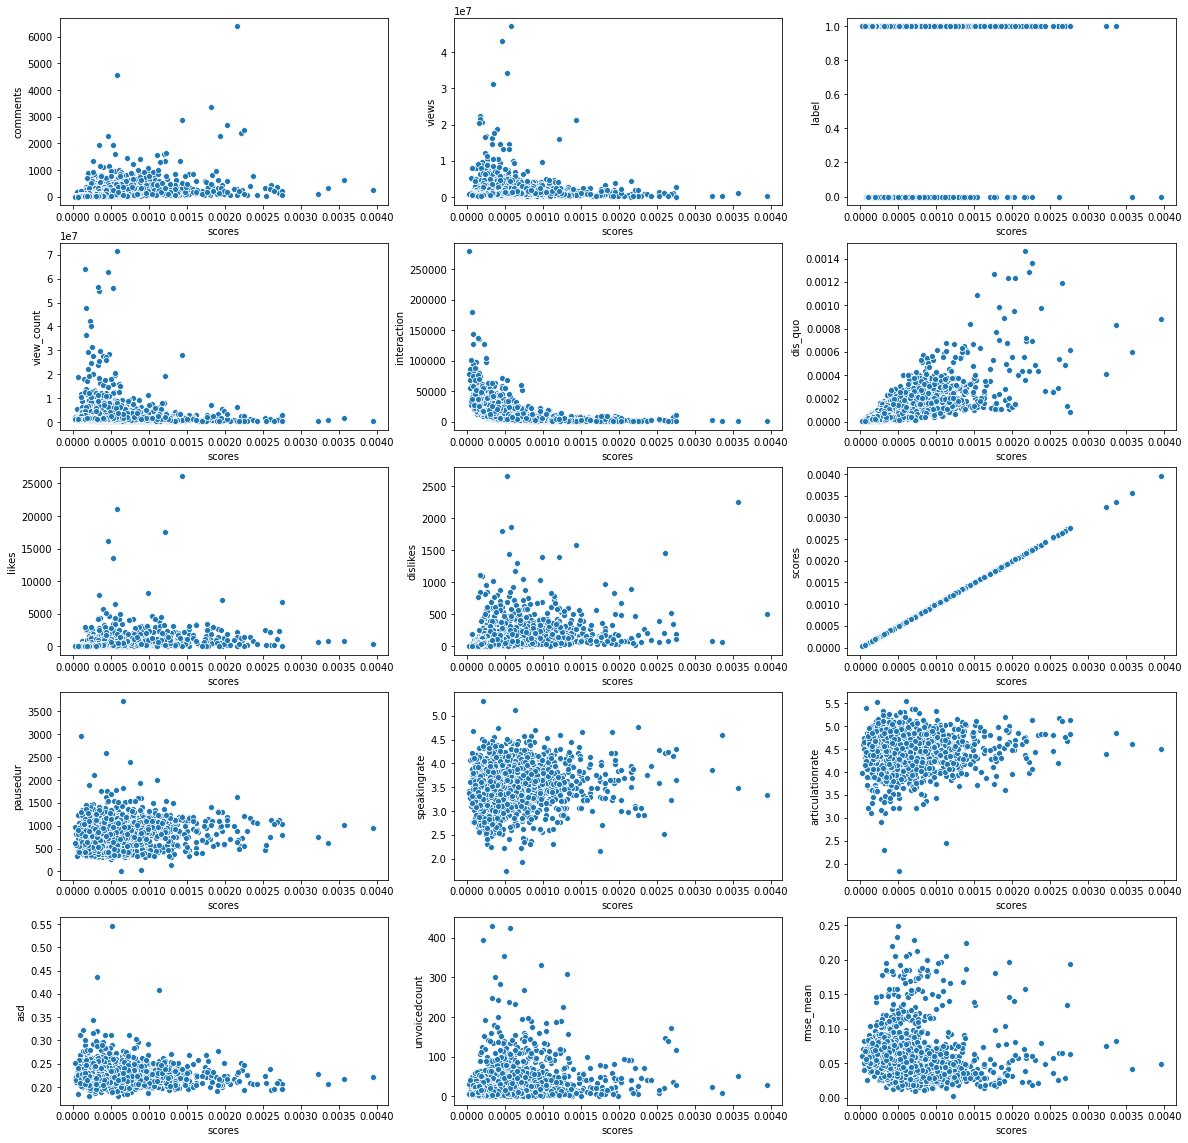

In [162]:
a = 5
b = 3
c = 1
fig = plt.figure(figsize=(20, 20))
for row_idx, col in enumerate(tgt_cols):
    plt.subplot(a, b, c)
    sns.scatterplot(x=ted_speech_df['scores'], y=ted_speech_df[col])
    plt.xlabel('scores')
    plt.ylabel(col)
    c += 1
plt.show()

### Outlier Analysis

(array([1.75e+03, 5.80e+01, 1.00e+01, 9.00e+00, 5.00e+00, 0.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 2.00e+00]),
 array([  117756. ,  4828691.4,  9539626.8, 14250562.2, 18961497.6,
        23672433. , 28383368.4, 33094303.8, 37805239.2, 42516174.6,
        47227110. ]),
 <a list of 10 Patch objects>)

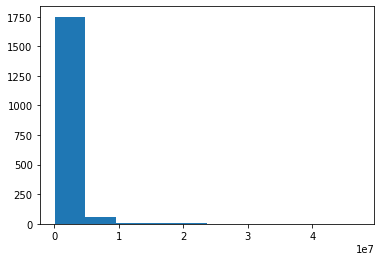

In [163]:
plt.hist(ted_speech_df['views'])

In [164]:
ted_speech_df['views'].describe(percentiles=[0.05,0.10,0.25,0.5,0.75,0.9,0.95])

count    1.836000e+03
mean     1.829691e+06
std      2.707271e+06
min      1.177560e+05
5%       4.621845e+05
10%      5.928145e+05
25%      8.696280e+05
50%      1.205220e+06
75%      1.801467e+06
90%      3.162710e+06
95%      4.693844e+06
max      4.722711e+07
Name: views, dtype: float64

Low dlr indices count for 459
High dlr indices count for 317



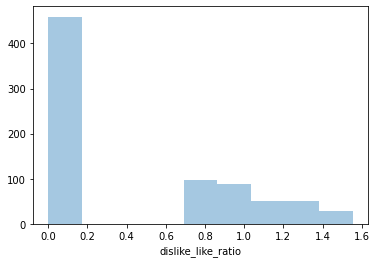

In [160]:
low_dlr_indices = []
high_dlr_indices = []

# for channel_title in h1_df['channelTitle'].unique():
# x_df = h1_df[h1_df['channelTitle'] == channel_title]

q25, q75 = np.percentile(ted_speech_df['dislike_like_ratio'], [25, 75])
iqr = q75 - q25

idx = []

valid_idx = ted_speech_df.index[((ted_speech_df['dislike_like_ratio'] <= q25) & 
                        (ted_speech_df['dislike_like_ratio'] > q25 - iqr*1.5))]

idx.extend(valid_idx.tolist())

print('Low dlr indices count for {}'.format(len(valid_idx)))
low_dlr_indices.extend(valid_idx.tolist())

valid_idx = ted_speech_df.index[((ted_speech_df['dislike_like_ratio'] >= q75) & 
                        (ted_speech_df['dislike_like_ratio'] < q75 + iqr*1.5))]

idx.extend(valid_idx.tolist())

print('High dlr indices count for {}\n'.format(len(valid_idx)))
high_dlr_indices.extend(valid_idx.tolist())

plt.figure()
sns.distplot(ted_speech_df.loc[idx]['dislike_like_ratio'], kde=False)
# plt.title(channel_title)
    
plt.show()

In [166]:
ted_speech_df.columns

Index(['comments', 'views', 'speaker_occupation', 'label', 'talk__id',
       'view_count', 'interaction', 'dis_quo', 'likes', 'dislikes', 'scores',
       'pausedur', 'speakingrate', 'articulationrate', 'asd', 'unvoicedcount',
       'rmse_mean', 'talk_id', 'dislike_like_ratio'],
      dtype='object')

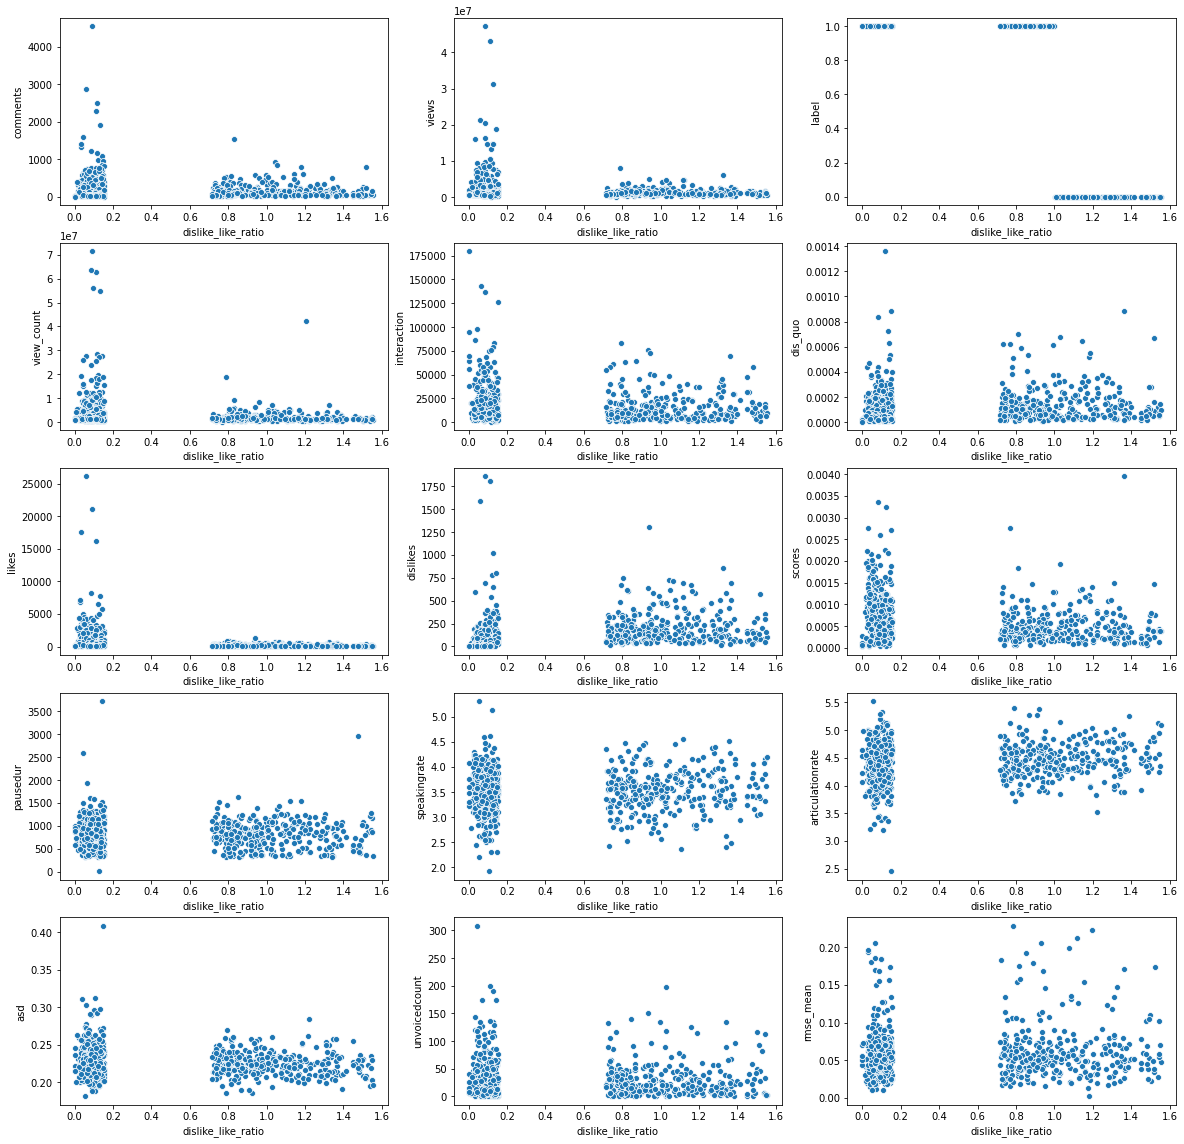

In [161]:
a = 5
b = 3
c = 1
fig = plt.figure(figsize=(20, 20))
for row_idx, col in enumerate(tgt_cols):
    df = ted_speech_df[ted_speech_df['']].loc[low_dlr_indices + high_dlr_indices]
    plt.subplot(a, b, c)
    sns.scatterplot(x=df['dislike_like_ratio'], y=df[col])
    plt.xlabel('dislike_like_ratio')
    plt.ylabel(col)
    c += 1
plt.show()

domain-wise dislike-like ratio

In [174]:
data.columns

Index(['speaker__id', 'comments', 'transcript', 'views', 'ratings',
       'speaker_occupation', 'languages', 'tags', 'speaker__is_published',
       'is_talk_featured', 'speaker__name', 'duration_y', 'label', 'title',
       'talk__id', 'view_count', 'published_date', 'description', 'event_y',
       'interaction', 'month', 'year', 'duration', 'dis_quo', 'likes',
       'dislikes', 'scores'],
      dtype='object')

In [ ]:
topic-wise patterns
non-semantic embeddings